# <center>4. Композиція моделей та оцінка інформативності ознак</center>
## <center>4.2 Послідовна композиція моделей</center>

Спочатку налаштуємо доступ до даних на google drive (якщо ви відкриваєте блокнот в google colab, а не на PC) шляхом монтування google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

MessageError: ignored

Перевіримо шлях до папки з матеріалами лаборатоної роботи на google drive. Якщо у вас шлях відрізняється то відредагуйте

In [ ]:
!ls gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lec_topic_4

data				      lec_4.1_bagging_ua.ipynb
data_science_03102022_part_1_ua.mp4   lec_4.1_bagging_ua.pdf
data_science_04102022_part_2_eng.mp4  lec_4.2_boosting_eng.ipynb
data_science_26092022_part_1_eng.mp4  lec_4.2_boosting_eng.pdf
img				      lec_4.2_boosting_ua.ipynb
lec_4.1_bagging_eng.ipynb	      lec_4.2_boosting_ua.pdf
lec_4.1_bagging_eng.pdf


Перемістимо матеріали лабораторної роботи з google drive на віртуальну машину google colab

In [ ]:
!cp -a gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lec_topic_4/. .
!ls

data				      lec_4.1_bagging_ua.ipynb
data_science_03102022_part_1_ua.mp4   lec_4.1_bagging_ua.pdf
data_science_04102022_part_2_eng.mp4  lec_4.2_boosting_eng.ipynb
data_science_26092022_part_1_eng.mp4  lec_4.2_boosting_eng.pdf
gdrive				      lec_4.2_boosting_ua.ipynb
img				      lec_4.2_boosting_ua.pdf
lec_4.1_bagging_eng.ipynb	      sample_data
lec_4.1_bagging_eng.pdf


## <center>Бустінг, градієнтний бустінг і Xgboost

Бустінг є жадібний алгоритм побудови композиції алгоритмів. Основна ідея полягає в тому, щоб, маючи безліч відносно слабких алгоритмів навчання, побудувати їх хорошу лінійну комбінацію. Він схожий на беггінг тим, що базовий алгоритм навчання фіксований. Відмінність полягає в тому, що навчання базових алгоритмів для композиції відбувається итеративно, і кожен наступний алгоритм прагне компенсувати недоліки композиції всіх попередніх алгоритмів.

На прикладі бустінга стало ясно, що гарною якістю можуть володіти як завгодно складні композиції класифікаторів, за умови, що вони правильно налаштовуються. Це розвіяло існуюче довгий час уявлення про те, що для підвищення узагальнюючої здатності необхідно обмежувати складність алгоритмів.

Згодом цей феномен бустінга отримав теоретичне обгрунтування. Виявилося, що зважене голосування не збільшує ефективну складність алгоритму, а лише згладжує відповіді базових алгоритмів. Ефективність бустінга пояснюється тим, що в міру додавання базових алгоритмів збільшуються відступи навчальних об'єктів. Причому бустінг продовжує розсовувати класи навіть після досягнення безпомилкової класифікації навчальної вибірки.

Загальна схема бустінгу:
- Шуканий ансамбль алгоритмів має вигляд $a(x) = \mbox{sign}(\sum_{t = 1}^T \alpha_t b_t(x))$, де $b_t$ - базові алгоритми.
- Ансамбль будується ітеративно, оптимізуючи на кожному кроці функціонал $Q_t$, що дорівнює кількості помилок в поточній композиції на навчальній вибірці.
- Під час додавання доданку $\alpha_t b_t(x)$ в суму, функціонал $Q_t$ оптимізується тільки за базовим алгоритмом $b_t(x)$ і коефіцієнт $\alpha_t$ при ньому, всі попередні доданки вважаються фіксованими.
- Функціонал $Q_t$ має вигляд суми за об'єктами навчальної вибірки порогових функцій вигляду $[y_i \sum_{j = 1}^t \alpha_j b_j(x_i) < 0]$, що означає "поточна композиція помиляється на об'єкті з номером $i$". Кожна така складова має вигляд "сходинки" і є розривною функцією. Для спрощення рішння задачі оптимізації таку порогову функцію замінюють на неперервну диференційовану оцінку зверху. В результаті отримується новий функціонал $\hat{Q}_t \geqslant Q_t$, мінімізація якого призводить до мінімізації початкового функціоналу $Q_t$.

Використовуючи різноманітні апроксимації для порогової функції втрат $[z < 0]$, будемо отримувати різні види бустінгу. Приклади:
- $e^{-z}$ - AdaBoost
- $\log_2(1 + e^{-z})$ - LogitBoost
- $(1 - z)^2$ - GentleBoost
- $e^{-cz(z+a)}$ - BrownBoost
- інші.

In [ ]:
import numpy as np
from urllib.request import urlopen
%matplotlib inline
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston

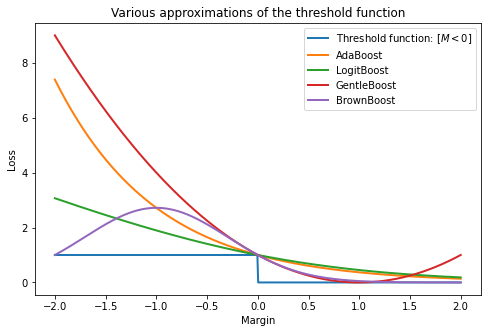

In [ ]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(8,5))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[M < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')
plt.xlabel('Margin')
plt.ylabel('Loss');

# Алгоритм AdaBoost

Як уже було сказано, алгоритм AdaBoost отримується з описаної схеми, під час апроксимації порогової функції втрат за допомогою функції $e^{-z}$. Існує теорема (Freund, Schapire, 1996), що дає для достатньо богатих сімейств базових класифікаторів явні формули для базового алгоритму $b_t(x)$ і коефіцієнта $\alpha_t$ при ньому, на яких досягається мінімум функціоналу $\hat{Q}_t$. 

Сам алгоритм виглядає наступним чином:
- Ініціалізувати ваги об'єктів $\Large w_i^{(0)} = \frac{1}{l}, i = 1, \dots, l$.
- Для всіх $t = 1, \dots, T$
    * Навчити базовий алгоритм $\Large b_t$, нехай $\epsilon_t$ – його помилка на навчальній вибірці.
    * $\Large \alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t}$.
    * Оновити ваги об'єктів: $\Large w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$.
    * Нормувати ваги об'єктів: $\Large w_0^{(t)} = \sum_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}}, i = 1, \dots, l$.
- Повернути $\sum_t^{T}\alpha_tb_t$

Таким чином, знову доданий алгоритм навчається шляхом мінімізації зваженої частоти помилок на навчальній вибірці, а не стандартного функціоналу, рівного частоті помилок. Вага об'єкта збільшується в $e^{\alpha_t}$ разів, коли $b_t$ допускає на ньому помилку, і зменшується у стільки ж разів, коли $b_t$ правильно класифікує цей об'єкт. Таким чином, безпосередньо перед налаштуванням базового алгоритму найбільша вага накопичується у тих об'єктів, які частіше виявлялися важкими для класифікації попередніми алгоритмами.

### Приклад для ілюстрації 
Нехай базові алгоритми – всього лиш "пеньки", тобто дерева рішень глибини 1.


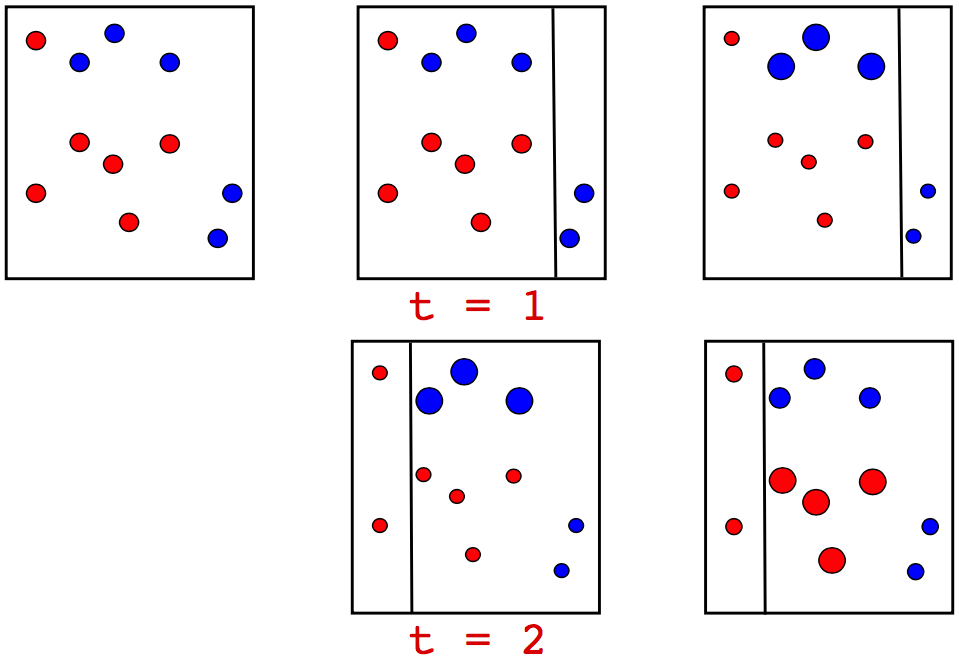

In [ ]:
from IPython.display import Image
Image('img/adaboost_toy_step1.png')

Ваги об'єктів, на яких базовий алгоритм помиляється, збільшуються (кружечки збільшуються в розмірі).


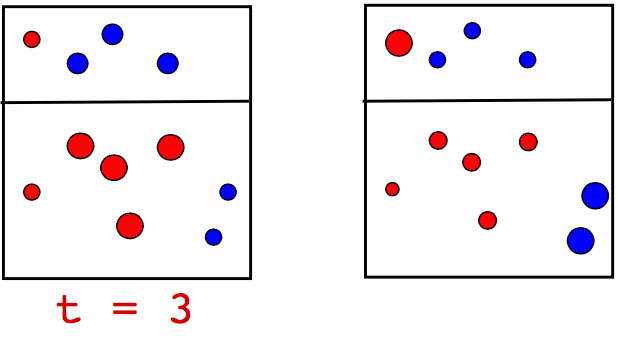

In [ ]:
from IPython.display import Image
Image('img/adaboost_toy_step2.png')


У кінці базові алгоритми "голосують", їх вага визначається $\alpha_t$ в процесі побудови.


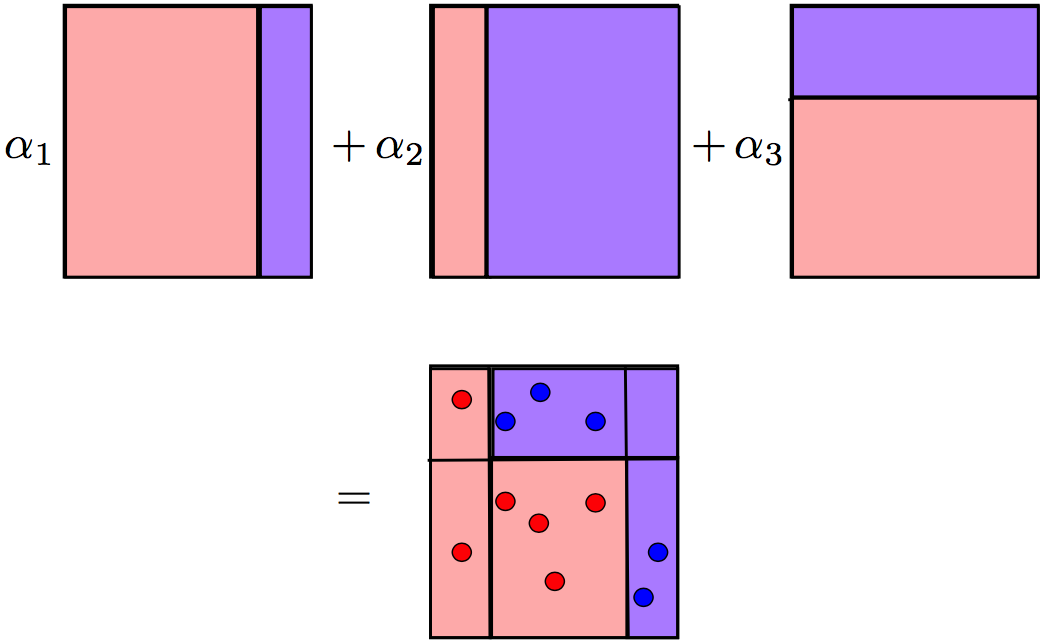

In [ ]:
from IPython.display import Image
Image('img/adaboost_toy_step3.png')

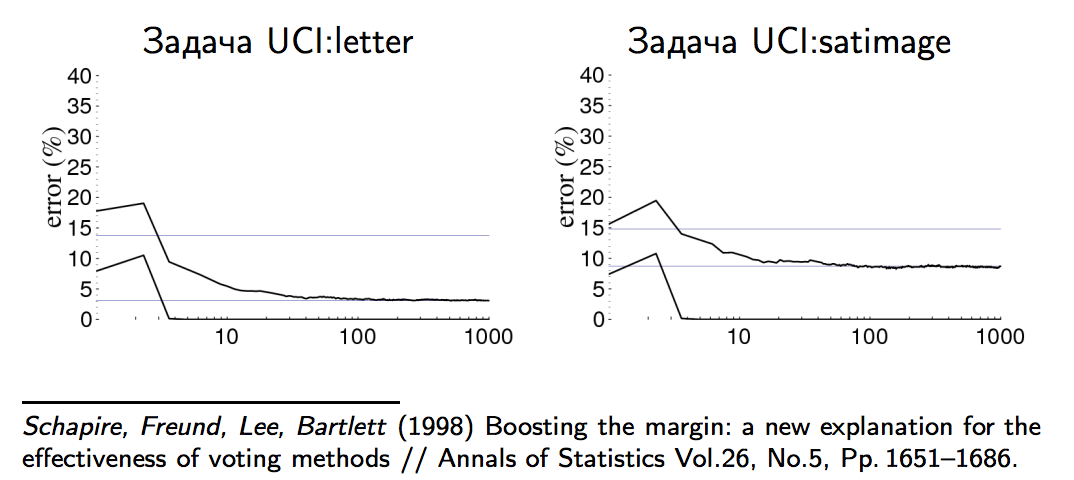

In [ ]:
from IPython.display import Image
Image('img/boosting_overfitting.png') #, width=640, height=480)

Спочатку було виявлено ВІДСУТНІСТЬ перенавчання бустінга аж до 1000 базових класифікаторів, пізніше це було теоретично обгрунтовано.

# Градієнтний бустінг
Метод градієнтного бустінга в деякому сенсі є узагальненням інших методів бустінга, оскільки він дозволяє оптимізувати довільну диференційовану функцію втрат. Даний алгоритм схожий на метод градієнтного спуску, застосовуваний для вирішення завдань оптимізації. Основна ідея полягає в тому, що кожен наступний алгоритм, що додається в композицію, налаштовується на залишки попередніх алгоритмів.

Нехай дано диференційовану функцію втрат $\Large L(F(x), y)$. Сам алгоритм виглядає наступним чином:
- Ініціалізація композиції константним значенням $\Large F_0(x) = \arg\min_{\alpha} \sum_{i=1}^n L(\alpha, y_i)$.
- Для всіх $\Large t = 1, \dots, T$:
    * Обчислити залишки попередньої композиції: 
    $\Large r_{it} = -[\nabla_{F(x)} L(F(x_i), y_i)]_{F(x) = F_{t-1}(x)}, i = 1, \dots, n$.
    * Налаштувати базовий алгоритм $\Large b_t(x)$ на отримані залишки, тобто навчити його на вибірці $\Large \{(x_i, r_{it}), i = 1, \dots, n\}$.
    * Обчислити коефіцієнт $\alpha_t$ перед базовим алгоритмом $\Large b_t(x)$ як рішення наступної одномірної задачі оптимізації:
    $\Large \alpha_t = \arg\min_\alpha \sum_{i=1}^n L(F_{t-1}(x_i) + \alpha b_t(x_i), y_i)$.
    * Додати отриманий доданок в композицію: $\Large F_t(x) = F_{t-1}(x) + \alpha_t b_t(x)$.

Однією з можливих модифікацій даного алгоритму є стохастичний градієнтний бустінг (SGB), який полягає в тому, щоб обчислювати суми виду $\sum_{i=1}^n$ не за всією навчальною вибіркою, а тільки за деякою її випадковою підвибіркою. Такий підхід є одним із способів регуляризації даного алгоритму і дозволяє поліпшити якість композиції, збіжність алгоритму і час навчання.

Інший спосіб регуляризації - це введення параметру $\gamma$, що називається темпом навчання. Під час додавання нового доданку в композицію, будемо додавати його, помноженим на цей коефіцієнт. Як правило, чим менший темп навчання, тим краща якість результивної композиції.

Для задач регресії, як правило, використовують квадратичну функцію втрат $L(x, y) = (x - y)^2$ або модуль відхилення $L(x, y) = |x - y|$.
В задачі класифікації використовується логістична функція втрат, яка дозволяє повертати ймовірність належності об'єктів до класів.

Одним з найбільш популярних базових алгоритмів є дерева рішень. Саме такий варіант градієнтного бустінгу <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">реалізований</a> в sklearn.

# Xgboost

Проблема багатьох алгоритмів побудови дерев в тому, що в них не приділяється достатньої уваги до регуляризації. 
В класичному градієнтному бустінгу застосовуються такі міри:
- обмеження на структуру дерев: максимальна глубина (max_depth), мінімальна кількість об'єктів в листках (min_samples_leaf)
- контроль темпу навчання (learning_rate)
- збільшення "несхожості" дерев за рахунок рандомізації, як у випадковому лісі.

[Xgboost](https://github.com/dmlc/xgboost) використовує ще більше параметрів для регуляризації базових дерев.

Цільова функція для оптимізації в Xgboost складається з двох доданків: специфічна функція втрат і регуляризатор $\Omega (f_k)$ для кожного з $K$ дерев, де $f_k$ - прогноз $k$-го дерева.


$$
obj(\theta) = \sum_{i}^{\ell} l(y_i - \hat{y_i}) +  \sum_{k=1}^{K} \Omega (f_k)
$$

Функція втрат залежить від вирішуваної задачі (Xgboost адаптовано під задачі класифікації, регресії і ранжування, (детально описано в [документації](http://xgboost.readthedocs.io/) Xgboost), а регуляризатор виглядає наступним чином:

$$
\Omega(f) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2
$$

Перший доданок ($\gamma T$) штрафує модель за більше число листків $T$, а другий ($\frac{1}{2} \lambda \sum_{j=1}^{T}w_j^2$) контролює суму ваг моделі в листках. 

# Приклади

В sklearn доступні алгоритми AdaBoost і GradientBoosting для задач класифікації і регресії.
Як приклад розглянемо рішення задачі відновлення одномірної регресії за допомогою <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a>.

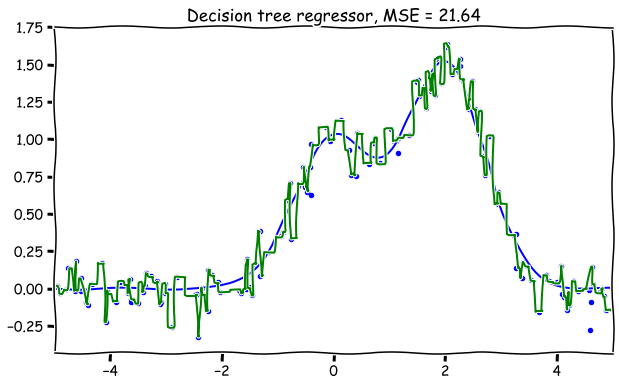

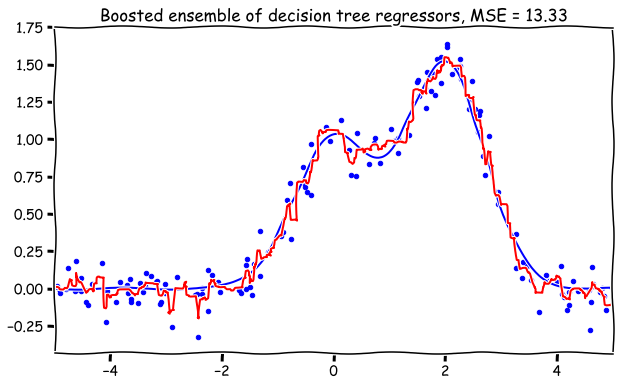

In [ ]:
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) +\
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)
# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

with plt.xkcd():
    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, d_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("Decision tree regressor, MSE = %.2f" % 
              np.sum((y_test - d_predict) ** 2))

    gbtree = GradientBoostingRegressor(n_estimators=100, subsample=0.5,
                                      random_state=42)  
    gbtree.fit(X_train, y_train)
    gb_predict = gbtree.predict(X_test)

    plt.figure(figsize=(10, 6))
    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, gb_predict, "r", lw=2)
    plt.xlim([-5, 5])
    plt.title("Boosted ensemble of decision tree regressors, MSE = %.2f" % 
              np.sum((y_test - gb_predict) ** 2));

Розглянемо наприклад використання AdaBoostClassifier з деревами рішень одиничної глибини (decision stumps) як базових алгоритмів для рішення задачі класифікації.

In [ ]:
# Loading Pima Indians Diabetes data from UCI Machine learning repository
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(data[:, :8], 
                                                    data[:, 8], 
                                                    random_state=0)

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

# AdaBoost
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         random_state=42).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("AdaBoost accuracy: %.2f" % ada.score(X_test, y_test))

Decision tree accuracy: 0.71
AdaBoost accuracy: 0.79


**Приклад використання Xgboost для класифікації на даних Iris.**

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']
kf = KFold(n_splits=5, shuffle=True, random_state=13)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBClassifier().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

[[ 9  0  0]
 [ 0  8  0]
 [ 0  2 11]]
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]
[[9 0 0]
 [0 9 1]
 [0 2 9]]
[[12  0  0]
 [ 0 10  1]
 [ 0  0  7]]
[[10  0  0]
 [ 0 11  0]
 [ 0  0  9]]


**Приклад відновлення регресії з Xgboost на даних boston.**

In [ ]:
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(n_splits=5, shuffle=True, random_state=17)
for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

8.0971394504
8.92640647601
18.299771839
6.73819144817
8.47392580766


**Простий приклад підбору параметрів з GridSearchCV.**

In [ ]:
X = boston['data']
y = boston['target']

xgb_model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6]}, verbose=1)
xgb_grid.fit(X,y)
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0.598487960649
{'max_depth': 4}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s finished


**Рання зупинка використовується для того, щоб зупинити навчання моделі (градієнтний спуск), якщо помилка протягом декількох ітерацій не зменшилась.**

In [ ]:
digits = load_digits()

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="merror",
        eval_set=[(X_test, y_test)])

[0]	validation_0-merror:0.177778
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.157778
[2]	validation_0-merror:0.148889
[3]	validation_0-merror:0.135556
[4]	validation_0-merror:0.131111
[5]	validation_0-merror:0.122222
[6]	validation_0-merror:0.106667
[7]	validation_0-merror:0.104444
[8]	validation_0-merror:0.104444
[9]	validation_0-merror:0.102222
[10]	validation_0-merror:0.097778
[11]	validation_0-merror:0.097778
[12]	validation_0-merror:0.095556
[13]	validation_0-merror:0.095556
[14]	validation_0-merror:0.097778
[15]	validation_0-merror:0.097778
[16]	validation_0-merror:0.093333
[17]	validation_0-merror:0.088889
[18]	validation_0-merror:0.091111
[19]	validation_0-merror:0.093333
[20]	validation_0-merror:0.091111
[21]	validation_0-merror:0.086667
[22]	validation_0-merror:0.084444
[23]	validation_0-merror:0.082222
[24]	validation_0-merror:0.082222
[25]	validation_0-merror:0.082222
[26]	validation_0-merror:0.082222
[27]	validation_0-merror:

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

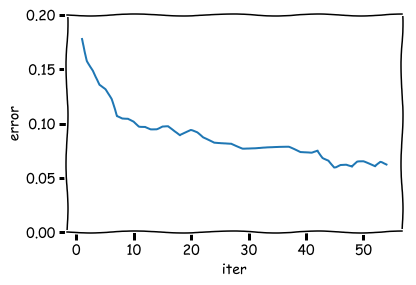

In [ ]:
errors_by_iter = clf.evals_result()['validation_0']['merror']
plt.plot(range(1, len(errors_by_iter) + 1), errors_by_iter)
plt.xlabel('iter');
plt.ylabel('error');
plt.ylim(0, 0.2);

## <center> Порівняння Xgboost і градієнтного бустінгу Sklearn</center>

## XGBoost

Виділяють три групи параметрів:
- Загальні параметри, що відповідають за базовий алгоритм для бустінгу і розпаралелювання.
- Параметри вибраного базового алгоритму.
- Параметри навчання, що відповідають за функцію втрат і метрику якості на валідації.

**1. Загальні параметри:**
- booster [default=gbtree] - тип базового алгоритму для бустінга: дерево рішень gbtree чи лінійна модель gblinear. 
- silent [default=0] - видавати (silent=0) чи ні (silent=1) повідомомлення під час роботи алгоритму.
- nthread [default to maximum number of threads available if not set] - кількість потоків доступних для паралельної роботи xgboost.

**2. Параметри базового алгоритму:**

**2.1. Дерев рішень:**
- eta [default=0.3] - темп навчання, перед додаванням дерева в композицію воно множиться на eta. Використовується для попередження перенавчання за рахунок "скорочення" ваг базових алгоритмів, роблячи модель більш консервативною. Чим менша eta, тим більше потрібно ітерацій num_boost_round для навчання моделі з хорошою якістю. Діапазон: [0, 1]
- gamma [default=0] - мінімальне зниження значення функції втрат, необхідне для подальшого розбиття вершини дерева. Більше значення gamma > 0 призводить до більш консервативних моделей. Діапазон: [0, $\infty$).
- max_depth [default=6] - максимальна глибина дерев. Діапазон: [1, $\infty$). 
- min_child_weight [default=1] - мінімально необхідна (зважена) кількість прикладів в кожній вершині. Чим більше, тим більше консервативна результивна модель. Діапазон: [0, $\infty$).
- max_delta_step [default=0] - як правило, рівний нулю. Додатнє значення використовується у випадку незбалансованих класів для прискорення збіжності. Діапазон [0, $\infty$).
- subsample [default=1] - частка вибірки, що використовується для навчання кожного дерева. Якщо subsample < 1, то вибираєтся випадкова підвибірка, що допомагає в боротьбі з перенавчанням. Діапазон: (0, 1]
- colsample_bytree [default=1] - частка ознак, що використовується для навчання кожного дерева. Діапазон: (0, 1]
- lambda [default=1] - коефіцієнт перед $L_2$-регуляризатором в функції втрат.
- alpha [default=0] - коефіцієнт перед $L_1$-регуляризатором в функції втрат.

**2.2. Лінійна модель:**
- lambda [default=0] - коефіцієнт перед $L_2$-регуляризатором вектора ваг в функції втрат.
- alpha [default=0] - коефіцієнт перед $L_1$-регуляризатором вектора ваг в функції втрат.
- lambda_bias [default=0] - коефіцієнт перед $L_2$-регуляризатором зміщення (вільного члена) в функції втрат.

**3. Параметри задачі навчання:**
- objective [default=reg:linear] -  функція втрат, що використовується під час навчання:
    - "reg:linear" – лінійна регресія.
    - "reg:logistic" – логістична регресія.
    - "binary:logistic" – логістична регресія для бінарної класифікації, на виході - ймовірність.
    - "binary:logitraw" – те ж саме, але на виході - значення до його перетворення логістичною функцією.
    - "count:poisson" – регресія Пуасона (використовується для оцінки числа будь-яких подій, лічильна ознака), на виході - маточікування розподілу Пуасона. В цьому випадку max_delta_step автоматично встановлюється рівним 0.7.
    - "multi:softmax" – узагальнення логістичної регресії на багатокласовий випадок. При цьому потрібно задати параметр num_class.
    - "multi:softprob" – те ж саме, але на виході - вектор разміру ndata * nclass, який можна перетворити в матрицю, що містить ймовірності віднесення даного об'єкта до даному класу.
    - "rank:pairwise" – використовується для задач ранжування.
- base_score [default=0.5] - ініціалізація значення моделі для всіх прикладів, глобальне зміщенння.
- eval_metric [default according to objective] - метрика якості на валідаційній вибірці (за замовчуванням відповідає функції втрат: rmse - для регресії, error - для класифікації, mean average precision - для ранжування). Вибрати можна одну з наступних метрик:
    - "rmse": root mean square error.
    - "logloss": мінус логарифм правдоподібності.
    - "error": доля помилок для бінарної класифікації.
    - "merror": те ж саме для багатокласової класифікації.
    - "mlogloss": logloss для багатокласової класифікації.
    - "auc": AUC.
    - "ndcg": Normalized Discounted Cumulative Gain.
    - "map": Mean average precision.
    - "ndcg@n",”map@n”: здесь n - ціле число, перші n позицій в списку не враховуються.
    - "ndcg-",”map-”,”ndcg@n-”,”map@n-”: списку з усіх позитивних прикладів буде присвоєно значення 0 (замість 1).
- seed [default=0] - для відтворюваності "випадковості".

**Параметри в xgboost.train**:
- params (dict) – параметри, описані вище.
- dtrain (DMatrix) – навчальна вибірка.
- num_boost_round (int) – кількість ітерацій бустінгу.
- evals (list) – список для оцінки якості під час навчання.
- obj (function) – власна функція втрат.
- feval (function) – власна функція для оцінки якості.
- maximize (bool) – чи потрібно максимізувати feval.
- early_stopping_rounds (int) – активує early stopping. Помилка на валідації повинна зменшуватися кожні early_stopping_rounds ітерацій для продовження навчання. Список evals повинен бути не пустим. Повертається модель з останньої ітерації. Якщо відбулася рання зупинка, то модель буде містити поля: bst.best_score и bst.best_iteration.
- evals_result (dict) – результати оцінки якості.
- verbose_eval (bool) – виведення значень метрики качества на каждой итерации бустинга.
- learning_rates (list or function) – коефіцієнт швидкості навчання для кожної ітерації - list l: eta = l[boosting round] - function f: eta = f(boosting round, num_boost_round).
- xgb_model (file name of stored xgb model or ‘Booster’ instance) – можливість продовжити навчання даної моделі XGB.


## sklearn.ensemble.GradientBoostingClassifier
- loss [default="deviance"] - функція втрат, що оптимізується.  Одна з {"deviance", "exponential"}. Перша відповідає логістичній регресії і повертає ймовірності, друга - AdaBoost.
- learning_rate [default=0.1] - темп навчання, аналогічно eta для XGBoost.
- n_estimators [default=100] - кількість ітерацій градієнтного бустінга.
- max_depth [default=3] - аналогічно max_depth для XGBoost.
- min_samples_split [default=2] - мінімальна кількість прикладів, необхідна для розгалудження в даній вершині,  аналогічно min_child_weight для XGBoost.
- min_samples_leaf [default=1] - мінімальна кількість прикладів у листку.
- min_weight_fraction_leaf [default=0.0] - мінімальна зважена кількість прикладів в листку.
- subsample [default=1.0] - аналогічно subsample для XGBoost.
- max_features (int, float, string or None) [default=None] - кількість (або частка) ознак, що використовуються під час розбиття вершини.
    - "auto", тогда max_features=sqrt(n_features).
    - "sqrt", тогда max_features=sqrt(n_features).
    - "log2", тогда max_features=log2(n_features).
    - None, тогда max_features=n_features.
- max_leaf_nodes [default=None]
- init (BaseEstimator or None) [default=None] - алгоритм для початкових прогнозів.
- verbose [default=0] - аналогічно silent для XGBoost.
- warm_start [default=False] - якщо True, використовується ансамбль з попереднього виклику fit, нові алгоритми додаються до нього, інакше будується новий алгоритм.

## Порівняння алгоритмів за часом роботи

Подивимося на час навчання класифікаторів XGBooster і GradientBoostingClassifier. Для цього будемо генерувати вибірку з 1000 об'єктів і 50 ознак за допомогою sklearn.datasets.make_classification і заміряти час навчання.

In [ ]:
import time
from tqdm import tqdm_notebook
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification

xgb_params1 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 1}
xgb_params2 = {'booster': 'gbtree', 'max_depth': 3, 'eta': 0.1, 
    'silent': 1, 'objective': 'binary:logistic', 'nthread': 4}
sklearn_params = {'n_estimators': 100, 'max_depth': 3}

xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

n_runs = 50

for i in tqdm_notebook(range(n_runs)):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, 
                               n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), 
                    num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

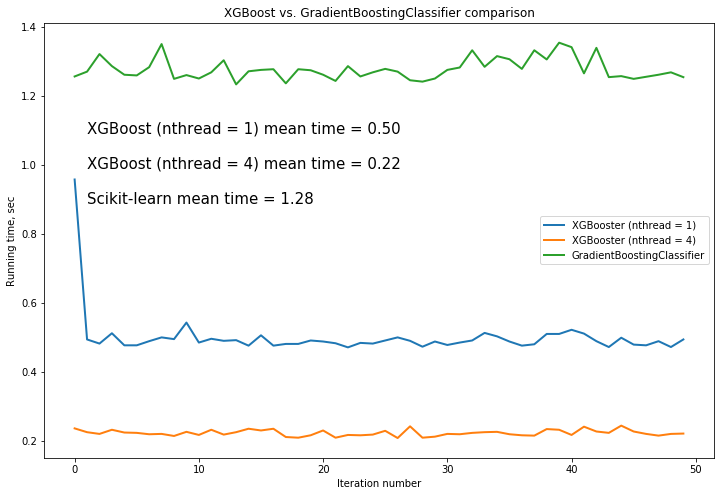

In [ ]:
%matplotlib  inline
import matplotlib.pyplot as plt

xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label='XGBooster (nthread = 1)', lw=2)
plt.plot(xgb_time2, label='XGBooster (nthread = 4)', lw=2)
plt.plot(sklearn_time, label='GradientBoostingClassifier', lw=2)
plt.legend(loc='best')
plt.text(1, (xgb_mean1 + sklearn_mean) / 2, 
         'XGBoost (nthread = 1) mean time = %.2f' % xgb_mean1 +
         '\n\nXGBoost (nthread = 4) mean time = %.2f' % xgb_mean2 +
         '\n\nScikit-learn mean time = %.2f' % sklearn_mean,
            fontsize = 15)
plt.xlabel('Iteration number')
plt.ylabel('Running time, sec')
plt.title('XGBoost vs. GradientBoostingClassifier comparison')
plt.show()

# Таким чином, переваги XGBoost у порівнянні з sklearn.ensembles.GradientBoostingClassifier такі:
- окрім дерев можна використовувати лінійні моделі як базові класифікатори;
- швидкість роботи;
- можливість розпаралелювання;
- значно більший вибір стандартних функцій втрат, а також можливість задавати свою функцію втрат;
- наявність регуляризатора в результивній функції втрат і можливість задавати їх коефіцієнти, що дає ще один метод боротьби з перенавчанням, окрім використання випадковості (subsample, colsample_bytree) і основних параметрів дерев рішень;
- вбудована обробка missing values.

## <center> Оцінка важливості ознак з Xgboost

## Завантаження бібліотек

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(font_scale = 1.5)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb

## Завантаження і подготовка даних

Подивимося на прикладі даних про відтік клієнтів з телеком-компанії. 

### Завантажимо дані

In [ ]:
df = pd.read_csv('data/telecom_churn.csv')

In [ ]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


**Штати просто пронумеруємо, а ознаки International plan (наявність міжнародного роумінгу) та Voice mail plan (наявність голосової почти) і цільову змінну Churn зробимо бінарними.**

In [ ]:
state_enc = LabelEncoder()
df['State'] = state_enc.fit_transform(df['State'])
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')
df['Churn'] = (df['Churn']).astype('int')

**Розділимо дані на навчальну і тестову вибірки у співвідношенні 7:3. Ініціалізуємо відповідні об'єкти DMatrix dtrain і dtest.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn', axis=1), df['Churn'],
                                                    test_size=0.3, stratify=df['Churn'], random_state=17)
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


### Навчання моделі

**Навчимо всього 50 дерев рішень глибини 3.**

In [ ]:
params = {
    'objective':'binary:logistic',
    'max_depth':3,
    'silent':1,
    'eta':0.5
}

num_rounds = 50

In [ ]:
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
xgb_model = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.116	train-error:0.09087
[1]	test-error:0.104	train-error:0.069867
[2]	test-error:0.089	train-error:0.061723
[3]	test-error:0.092	train-error:0.054008
[4]	test-error:0.075	train-error:0.041149
[5]	test-error:0.074	train-error:0.038148
[6]	test-error:0.07	train-error:0.035148
[7]	test-error:0.069	train-error:0.033005
[8]	test-error:0.069	train-error:0.033433
[9]	test-error:0.068	train-error:0.029147
[10]	test-error:0.066	train-error:0.031719
[11]	test-error:0.068	train-error:0.028718
[12]	test-error:0.068	train-error:0.027004
[13]	test-error:0.069	train-error:0.027004
[14]	test-error:0.07	train-error:0.027004
[15]	test-error:0.071	train-error:0.026575
[16]	test-error:0.069	train-error:0.025718
[17]	test-error:0.07	train-error:0.025718
[18]	test-error:0.068	train-error:0.025718
[19]	test-error:0.071	train-error:0.025718
[20]	test-error:0.07	train-error:0.026147
[21]	test-error:0.069	train-error:0.025289
[22]	test-error:0.069	train-error:0.025718
[23]	test-error:0.068	trai

### Важливість ознак

**F score під час оцінки важливості ознак в Xgboost (не плутати з F1 score як метрики якості класифікації) обчислюється на основі того, як часто розбиття робилося за даною ознакою.**

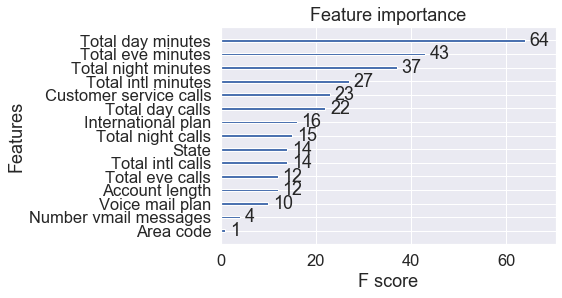

In [ ]:
xgb.plot_importance(xgb_model);

**Можно також у вигляді словника чи DataFrame:**

In [ ]:
importances = xgb_model.get_fscore()
importances

{'Customer service calls': 23,
 'Total day minutes': 64,
 'International plan': 16,
 'Voice mail plan': 10,
 'Total eve minutes': 43,
 'Number vmail messages': 4,
 'Total intl calls': 14,
 'Total night minutes': 37,
 'Total intl minutes': 27,
 'Account length': 12,
 'State': 14,
 'Total day calls': 22,
 'Total night calls': 15,
 'Total eve calls': 12,
 'Area code': 1}

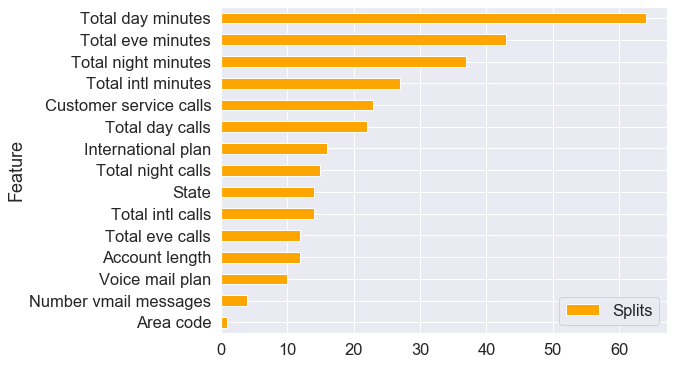

In [ ]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange');

## <center> Оптимізація параметів моделі Xgboost з використанням hyperopt

In [ ]:
!pip install hyperopt

In [ ]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [ ]:
classes_num = 2

def score(params):
    from sklearn.metrics import log_loss
    print("Training with params:")
    print(params)
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params['num_round'])
    
    predictions = model.predict(dvalid).reshape((X_test.shape[0], classes_num))
    
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [ ]:
def optimize(trials):
    space = {
             'num_round': 100,
             'learning_rate': hp.quniform('eta', 0.005, 0.05, 0.005),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'num_class' : classes_num,
             'eval_metric': 'merror',
             'objective': 'multi:softprob',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [ ]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:                                                                                                  
{'colsample_bytree': 0.9, 'eval_metric': 'merror', 'gamma': 0.9, 'learning_rate': 0.005, 'max_depth': 6.0, 'min_child_weight': 6.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8500000000000001}
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.44074599832296374                                                                                             


Training with params:                                                                                                  
{'colsample_bytree': 0.65, 'eval_metric': 'merror', 'gamma': 0.74, 'learning_rate': 0.035, 'max_depth': 10.0, 'min_child_weight': 2.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.9500000000000001}
 10%|████▊                                           | 1/10 [00:00<00:04,  1.94trial/s, best loss: 0.44074599832296374]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.20070104175060988                                                                                             


Training with params:                                                                                                  
{'colsample_bytree': 0.45, 'eval_metric': 'merror', 'gamma': 0.53, 'learning_rate': 0.04, 'max_depth': 5.0, 'min_child_weight': 2.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.7000000000000001}
 20%|█████████▌                                      | 2/10 [00:01<00:04,  1.74trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2212722280267626                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.7000000000000001, 'eval_metric': 'merror', 'gamma': 0.76, 'learning_rate': 0.04, 'max_depth': 10.0, 'min_child_weight': 10.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8500000000000001}
 30%|██████████████▍                                 | 3/10 [00:01<00:03,  1.88trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.20554671631194651                                                                                             


Training with params:                                                                                                  
{'colsample_bytree': 0.45, 'eval_metric': 'merror', 'gamma': 0.9, 'learning_rate': 0.015, 'max_depth': 4.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8}
 40%|███████████████████▏                            | 4/10 [00:02<00:03,  1.83trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.3194730317145586                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.55, 'eval_metric': 'merror', 'gamma': 0.68, 'learning_rate': 0.01, 'max_depth': 12.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.75}
 50%|████████████████████████                        | 5/10 [00:02<00:02,  2.04trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.36141393998265264                                                                                             


Training with params:                                                                                                  
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'merror', 'gamma': 0.68, 'learning_rate': 0.01, 'max_depth': 12.0, 'min_child_weight': 7.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.7000000000000001}
 60%|████████████████████████████▊                   | 6/10 [00:03<00:02,  1.98trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.32895921640098097                                                                                             


Training with params:                                                                                                  
{'colsample_bytree': 0.9, 'eval_metric': 'merror', 'gamma': 0.71, 'learning_rate': 0.025, 'max_depth': 13.0, 'min_child_weight': 3.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.9}
 70%|█████████████████████████████████▌              | 7/10 [00:03<00:01,  1.88trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.20361336081847548                                                                                             


Training with params:                                                                                                  
{'colsample_bytree': 0.75, 'eval_metric': 'merror', 'gamma': 0.68, 'learning_rate': 0.025, 'max_depth': 11.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.75}
 80%|██████████████████████████████████████▍         | 8/10 [00:04<00:01,  1.64trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.2267263038828969                                                                                              


Training with params:                                                                                                  
{'colsample_bytree': 0.75, 'eval_metric': 'merror', 'gamma': 0.74, 'learning_rate': 0.045, 'max_depth': 8.0, 'min_child_weight': 3.0, 'nthread': 4, 'num_class': 2, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.7000000000000001}
 90%|███████████████████████████████████████████▏    | 9/10 [00:05<00:00,  1.68trial/s, best loss: 0.20070104175060988]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \



	Score 0.19391451905295254                                                                                             


100%|███████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68trial/s, best loss: 0.19391451905295254]


{'colsample_bytree': 0.75,
 'eta': 0.045,
 'gamma': 0.74,
 'max_depth': 8.0,
 'min_child_weight': 3.0,
 'subsample': 0.7000000000000001}

In [ ]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['num_class'] = classes_num
best_params['eval_metric'] = 'merror'
best_params['objective'] = 'multi:softprob'
best_params['nthread'] = 4
best_params['silent'] = 1

In [ ]:
%%time
xgbCvResult = xgb.cv(best_params, dtrain, 
                      num_boost_round=500,  
                      nfold=3, early_stopping_rounds=50)

best_num_round = np.argmin(xgbCvResult['test-merror-mean'])
best_num_round

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Wall time: 3.38 s


164

**Зробимо прогноз для всієї тестової вибірки.**

In [ ]:
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)
xgboost_predict_proba = bestXgb.predict(dtest)
xgboost_prediction = np.argmax(xgboost_predict_proba, axis=1)

xgboost_prediction

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

## Корисні посилання
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting</a>
- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- <a href="https://github.com/dmlc/xgboost">Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> рішення переможця змагання Kaggle "CrowdFlower" з прогнозування релевантноств видачі пошуковика товарів. Рішення на основі Xgboost